In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn
from sklearn import *
import numpy as np
import networkx as nx
import os
a
np.random.seed(42)

In [2]:
! rm images/*.png

## Logistic Graph Modeling


### Objective:
To model the probability of a connection between two vertices in a graph using a logistic function.

### Equation:
\[
\text{prob\_of\_vertex}_{i,j} = \frac{c}{1 + \beta \exp(|i| + |j|)}
\]

Where:
- \( \text{prob\_of\_vertex}_{i,j} \) is the probability of a connection between vertices \( i \) and \( j \).
- \( c \) is the initial probability.
- \( \beta \) is a parameter that modulates the exponential term.

### Steps:
1. **Initialization**:
   - Set \( n \): Number of vertices.
   - Set \( c \): Initial probability (e.g., \( 1 \times 10^{-3} \)).
   - Set \( \beta \): A low value to start with.
  
2. **Logistic Regression**:
   - Use the given logistic function to compute the probability of a connection between vertices \( i \) and \( j \).

3. **Convergence**:
   - Monitor the model for convergence. The exact criterion for convergence isn't predefined.

4. **Parameter Estimation**:
   - Estimate \( c_{\text{hat}} \) and \( \beta_{\text{hat}} \).
   - Assess the goodness of fit of the estimations.

5. **Iterative Refinement**:
   - Incorporate more parameters based on the connectivity of the vertices.
   - For instance, for a vertex \( i \), consider all vertices connected to \( i \), and for vertex \( j \), consider all vertices connected to \( j \) and so on.
   - Repeat the logistic regression with increasing order \( p \) (up to \( p \leq 4 \)).

### Note:
The methodology seems to be an iterative approach to improve the modeling of vertex connectivity. The inclusion of more parameters based on connected vertices in step 5 suggests that the model may try to capture higher-order relationships or dependencies between vertices in the graph.

In [3]:
from src.utils import * 
from src.graph import * 

# Creating the graph using the logit model

In [4]:
def populate_edges(graph, c, beta, p, threshold=.5, plot_interval=0.05, warm_up=50, max_iterations=100, sigma=1, pos=None):
    """Main function that uses all the above functions to fill the graph with edges."""
    i = 0
    stop_condition = False

    #previous_graph = graph.copy()  # Initialize the previous graph to the initial graph
    graphs = [graph] # list to store the graphs
    spectra = []  # List to store the spectrum at each iteration

    output_folder = 'images'

    while i < max_iterations and (i < warm_up or not stop_condition):
        graph = add_vertex(graph, c, beta, p, threshold, sigma)
        spectrum = calculate_spectrum(graph)

        spectra.append(spectrum)
        graphs.append(graph)

        #stop_condition = check_convergence(graphs[-1], graphs[-2], tolerance=1)
        if i > warm_up:
            #stop_condition = check_convergence(graphs, tolerance=1)
            stop_condiiton = False
        #previous_graph = graph.copy()  # Update the previous graph

        if i % int(max_iterations * plot_interval) == 0:
            print(i)
            filename = os.path.join(output_folder, f'{i}.png')
            #plot_graph_from_adjacency(graph, filename, pos=pos, title='iter: ' + str(i))
            plot_graph_and_spectrum(graph, spectrum, filename, pos=pos, title=f'Evolution: iteration {i}')
        
        i += 1
    
    return graphs, spectra

In [5]:
graph = initialize_graph(30)
#G = nx.Graph()
#n = len(graph)
#for i in range(n):
#    for j in range(n):
#        if graph[i][j] == 0 and i !=j :
#            G.add_edge(i, j)
G = nx.from_numpy_array(graph)
pos = nx.spring_layout(G)

####################
beta = 1e-5
c = 1e-4

p = 0 # Vizinhos
threshold = .5
sigma = 10
max_iterations = 3000
warm_up=200
####################

graphs, spectra = populate_edges(graph, c=c, beta=beta, p=p, threshold = threshold,
                                max_iterations = max_iterations , warm_up=warm_up,  
                                sigma=sigma, plot_interval=0.025, pos=pos)

0
75
150
225
300
375
450
525
600
675
750
825
900
975
1050
1125
1200
1275
1350
1425
1500
1575
1650
1725
1800
1875
1950
2025
2100
2175
2250
2325
2400
2475
2550
2625
2700
2775
2850
2925


In [6]:
#graphs[-1]

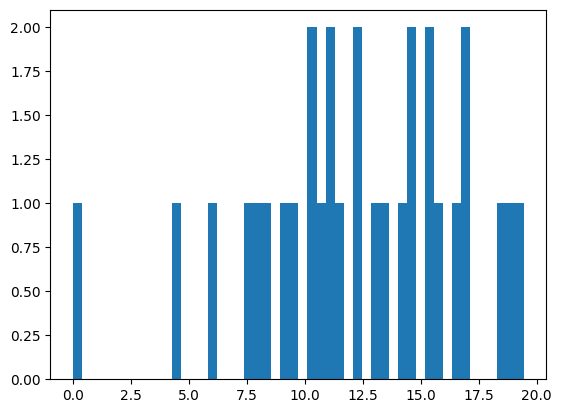

In [7]:
spectra = np.array(spectra)
plt.hist(spectra[-1], bins=50)
plt.show()

In [8]:
import os
import imageio

output_folder = 'images'

In [9]:
# Call create_gif_from_images to create the GIF
create_gif_from_images(output_folder, 'graph_animation.gif')

In [10]:
G = nx.from_numpy_array(graph)

# Verify the maximum degree of the graph
print('maximum degree')
max(G.degree, key=lambda x: x[1])

maximum degree


(6, 17)

# Modifications on the logit model

* Added dynamical threshold
* Added damping factor

In [11]:
def calculate_graph_density(graph):
    """Calculates the density of the graph."""
    n, m = graph.shape
    number_of_edges = np.sum(graph) / 2  # Divided by 2 because the graph is undirected
    max_possible_edges = n * (n - 1) / 2
    return number_of_edges / max_possible_edges

def dynamic_threshold(graph, base_threshold=0.3, alpha=0.5):
    """Calculates a dynamic threshold based on the graph's density."""
    density = calculate_graph_density(graph)
    return base_threshold + alpha * density

def refined_logistic_regression(c, beta, sum_degrees, alpha=1, gamma=0.05):
    """Refined logistic regression function with modified exponential term."""
    num     = c
    denom   = 1 + beta * np.exp(-alpha * sum_degrees + gamma * sum_degrees**2)
    return num / denom

def get_edge_logit_refined(c, beta, sum_degrees, threshold, alpha=1, gamma=0.01):
    """Decides if an edge should be added based on the refined logistic regression output and a threshold."""
    return 1 if refined_logistic_regression(c, beta, sum_degrees, alpha, gamma) >= threshold else 0

def add_vertex_with_dynamic_threshold(graph, c, beta, p, base_threshold=0.3, alpha=0.5, gamma=0.001, sigma=1):
    """Iterates over the graph's vertices and decides if an edge will be added using a dynamic threshold."""
    n, m = graph.shape
    for i in range(n):
        for j in range(m):
            if i != j and graph[i,j] == 0:
                sum_degrees_i = get_sum_degrees(graph, i, p)
                sum_degrees_j = get_sum_degrees(graph, j, p)
                sum_degrees = sum_degrees_i + sum_degrees_j + np.random.normal(0,sigma)
                threshold = dynamic_threshold(graph, base_threshold, alpha)
                #graph[i, j] = get_edge_logit(c, beta, sum_degrees, threshold)
                graph[i, j] = get_edge_logit_refined(c, beta, sum_degrees, threshold, alpha, gamma)
    return graph

def populate_edges_with_dynamic_threshold(graph, c, beta, p, base_threshold=0.3, alpha=0.5, max_iterations=10000):
    """Main function that uses all the above functions to fill the graph with edges using a dynamic threshold."""
    i = 0
    stop_condition = False
    previous_graph = graph.copy()  # Initialize the previous graph to the initial graph
    while i < max_iterations or not stop_condition:
        graph = add_vertex_with_dynamic_threshold(graph, c, beta, p, base_threshold, alpha)
        stop_condition = check_convergence(graph, previous_graph)
        previous_graph = graph.copy()  # Update the previous graph
        if i % int(max_iterations * 0.1) == 0:
            plot_graph_from_adjacency(graph)
        i += 1
    return graph


# Test the modified functions
test_graph = initialize_graph(10)
c = 1e-3
beta = 2e-3
p = 0
populated_graph_dynamic_threshold = populate_edges_with_dynamic_threshold(test_graph, c=c, beta=beta, p=p)


IndexError: index -11 is out of bounds for axis 0 with size 10

# Estimate parameters of the graph above

In [ ]:
def estimate_parameters():
    return 0